# Walkthrough of compiling an activity map
Compiling an activity map requires:
- Querying `DATASET1_CellTable.csv` for relevant neurons
- Querying `DATASET1_TrialTable.csv` for relevant trials
- Querying H5 files for spike trains associated with relevant neurons and trials.

In this notebook, we walkthrough each step with minimal imports.

## Imports

In [1]:
%cd ../../
%load_ext autoreload
%autoreload 2

/home/jovyan/work/task-priors


In [2]:
import os
import h5py

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from scipy.ndimage import gaussian_filter1d

## File paths

In [3]:
celltable_path = './data/DATASET1_CellTable.csv'
trialtable_path = './data/DATASET1_TrialTable.csv'
h5_directory_path = 'data/DATASET1_CellTrialTable'

## Parameters for activity map

In [4]:
experimental_day = 'D1'
visual_stimulus = 45
trial_length = 105 # To denote how many time bins to include in matrix

## Load `CellTable` and `TrialTable` csv

In [5]:
df_celltable = pd.read_csv(celltable_path)
df_celltable

/tmp/ipykernel_16875/3949516980.py:1: DtypeWarning: Columns (6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_celltable = pd.read_csv(celltable_path)


,Cell,Experiment,Zscore,DeconvA_Tau,nSpikeTC,DeconvCorr,Tuning_Curve_spikes_1,Best_Fit_spikes_1,Pref_Orientation_spikes_1,Tuning_Width_spikes_1,...,Pref_Orientation_AuC_2,Tuning_Width_AuC_2,DSI_AuC_2,OSI_AuC_2,isCell,nPix,spikeProb_TCTrials,roundness,radius,magFactor
0,1,B10_110920,22.635183,0x0001494D000000000E00000038000000060000000800...,4386.0,0.987410,0x0001494D000000000E000000700B0000060000000800...,circular_gaussian_360,185.0,17.773541,...,NaN,NaN,NaN,NaN,0.349529,60,0.100000,0.027616,25.668601,0.5
1,2,B10_110920,15.369622,0x0001494D000000000E00000038000000060000000800...,2901.0,0.984389,0x0001494D000000000E000000700B0000060000000800...,circular_gaussian_360,345.0,25.697329,...,NaN,NaN,NaN,NaN,0.348195,224,0.100000,0.580381,10.839231,0.5
2,3,B10_110920,17.427969,0x0001494D000000000E00000038000000060000000800...,3618.0,0.987856,0x0001494D000000000E000000700B0000060000000800...,direction_selective_circular_gaussian,345.0,17.029670,...,NaN,NaN,NaN,NaN,0.741653,143,1.000000,0.660099,8.062258,0.5
3,4,B10_110920,32.957703,0x0001494D000000000E00000038000000060000000800...,9074.0,0.986769,0x0001494D000000000E000000700B0000060000000800...,circular_gaussian_180,92.0,16.415984,...,NaN,NaN,NaN,NaN,0.832610,55,0.578947,0.625000,5.288874,0.5
4,5,B10_110920,19.673850,0x0001494D000000000E00000038000000060000000800...,2459.0,0.964936,0x0001494D000000000E000000700B0000060000000800...,direction_selective_circular_gaussian,89.0,16.171344,...,NaN,NaN,NaN,NaN,0.948684,20,0.157895,0.169492,6.203659,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81914,1045,F19_42521_,6.097245,0x0001494D000000000E00000038000000060000000800...,1036.0,0.887467,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.761826,105,NaN,0.298193,10.258606,0.5
81915,1046,F19_42521_,4.753120,0x0001494D000000000E00000038000000060000000800...,118.0,0.594590,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.345374,70,0.200000,0.814815,5.099020,0.5
81916,1047,F19_42521_,7.626988,0x0001494D000000000E00000038000000060000000800...,178.0,0.731369,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.546211,41,0.050000,0.075435,12.927577,0.5
81917,1048,F19_42521_,6.314923,0x0001494D000000000E00000038000000060000000800...,616.0,0.800716,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.812365,53,NaN,0.091071,13.313356,0.5


In [6]:
df_trialtable = pd.read_csv(trialtable_path)
df_trialtable

,Trial,Experiment,Behav_Cond,Block,Visual_Stim,Auditory_Stim,Contrast,Response,Outcome,Lick_trace,Lick_dt,Locomotion_trace,Locomotion_mean_01,Pupil_Area_trace,Pupil_Area_mean_01,Pupil_Position_traceX,Pupil_Position_traceY
0,105,F06_42421_,D4,Visual,45,-1,0.25,1,Hit,0x0001494D000000000E000000C01E0400060000000800...,0.0004,NaN,NaN,0x0001494D000000000E000000C0060000060000000800...,258.920712,0x0001494D000000000E000000C0060000060000000800...,0x0001494D000000000E000000C0060000060000000800...
1,106,F06_42421_,D4,Visual,70,-1,0.25,0,CR,0x0001494D000000000E000000701E0400060000000800...,0.0004,NaN,NaN,0x0001494D000000000E000000C0060000060000000800...,275.610433,0x0001494D000000000E000000C0060000060000000800...,0x0001494D000000000E000000C0060000060000000800...
2,107,F06_42421_,D4,Visual,70,-1,0.25,1,FA,0x0001494D000000000E000000801E0400060000000800...,0.0004,NaN,NaN,0x0001494D000000000E000000C0060000060000000800...,217.971594,0x0001494D000000000E000000C0060000060000000800...,0x0001494D000000000E000000C0060000060000000800...
3,108,F06_42421_,D4,Visual,70,-1,0.25,0,CR,0x0001494D000000000E000000901E0400060000000800...,0.0004,NaN,NaN,0x0001494D000000000E000000B8060000060000000800...,210.932547,0x0001494D000000000E000000B8060000060000000800...,0x0001494D000000000E000000B8060000060000000800...
4,109,F06_42421_,D4,Visual,45,-1,0.25,1,Hit,0x0001494D000000000E000000B01E0400060000000800...,0.0004,NaN,NaN,0x0001494D000000000E000000B8060000060000000800...,460.904285,0x0001494D000000000E000000B8060000060000000800...,0x0001494D000000000E000000B8060000060000000800...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24480,414,F19_42521_,D6,Orientation Tuning,330,-1,1.00,0,No task,0x0001494D000000000E00000010AC0300060000000800...,0.0004,0x0001494D000000000E00000008060000060000000800...,5.141089,0x0001494D000000000E00000008060000060000000800...,888.139077,0x0001494D000000000E00000008060000060000000800...,0x0001494D000000000E00000008060000060000000800...
24481,415,F19_42521_,D6,Orientation Tuning,90,-1,1.00,0,No task,0x0001494D000000000E00000018AC0300060000000800...,0.0004,0x0001494D000000000E00000008060000060000000800...,5.988349,0x0001494D000000000E00000008060000060000000800...,962.990798,0x0001494D000000000E00000008060000060000000800...,0x0001494D000000000E00000008060000060000000800...
24482,416,F19_42521_,D6,Orientation Tuning,300,-1,1.00,0,No task,0x0001494D000000000E00000068AD0300060000000800...,0.0004,0x0001494D000000000E00000008060000060000000800...,-0.285791,0x0001494D000000000E00000008060000060000000800...,980.958689,0x0001494D000000000E00000008060000060000000800...,0x0001494D000000000E00000008060000060000000800...
24483,417,F19_42521_,D6,Orientation Tuning,120,-1,1.00,0,No task,0x0001494D000000000E00000068AD0300060000000800...,0.0004,0x0001494D000000000E00000008060000060000000800...,8.265638,0x0001494D000000000E00000008060000060000000800...,967.299838,0x0001494D000000000E00000008060000060000000800...,0x0001494D000000000E00000008060000060000000800...


## Query relevant experimental ids

In [7]:
experiments_relevant = df_trialtable[
    (df_trialtable['Behav_Cond'] == experimental_day)
]
relevant_experiment_ids = list(experiments_relevant['Experiment'].unique())
relevant_experiment_ids

['B10_110920',
 'F07_42021_',
 'C02_121020',
 'C05_121020',
 'F05_42021_',
 'F06_42121_',
 'F09_42021_',
 'F10_42121_',
 'F17_42021_',
 'F19_42021_']

## Compile trial bank
A trial bank is a dictionary where the keys are experimental ids and the values are lists of trials with the specified stimulus and the experimental block.

In [8]:
trial_bank = {}

for experiment_id in relevant_experiment_ids:
    df_experiment = df_trialtable[df_trialtable['Experiment'] == experiment_id]
    df_relevant_trials = df_experiment[
        (df_experiment['Behav_Cond'] == experimental_day) &\
        (df_experiment['Block'] == 'Visual') &\
        (df_experiment['Visual_Stim'] == visual_stimulus)
    ]
    trials = np.sort(df_relevant_trials['Trial'].unique())
    trial_bank[experiment_id] = trials

In [9]:
trial_bank['B10_110920']

array([121, 122, 124, 125, 127, 128, 131, 133, 134, 138, 141, 142, 143,
       146, 149, 150, 153, 154, 155, 157, 158, 160, 163, 164, 168, 171,
       172, 173, 176, 177, 179, 182, 186, 188, 190, 194, 197, 200, 201,
       204, 205, 206, 208, 209, 210, 214, 216, 220, 223, 225, 226, 229,
       230, 231, 233, 234, 235, 237, 239, 242, 243, 247, 248, 249, 253,
       254, 255, 257, 258, 259, 262, 264, 265, 266, 268, 270, 272, 274,
       276, 279, 281, 283, 284, 287, 289, 290, 294, 295, 298, 302, 303,
       305, 307, 309, 311, 312, 313, 315, 319, 322, 325, 328, 330, 331,
       334, 336, 337, 339, 340, 341, 344, 348, 351, 352, 353, 355, 356,
       359, 361, 365, 367, 369, 370, 372, 375, 376, 379, 380, 382, 383,
       386, 387, 388, 390, 394, 397, 399, 400, 403, 405, 406, 409, 410,
       412, 413, 414, 417])

## Query admissible neurons
The criteria for which neurons can be included comes from [https://zenodo.org/records/8109858](https://zenodo.org/records/8109858).

In [10]:
fit_key = 'Best_Fit_spikes_2'
orientation_key = 'Pref_Orientation_spikes_2'

In [11]:
admissible_neurons = df_celltable[
    (df_celltable['Experiment'].isin(relevant_experiment_ids)) &\
    (~df_celltable[fit_key].isna()) &\
    (df_celltable['DeconvCorr'] > 0.8) &\
    (df_celltable['isCell'] > 0.8) &\
    (df_celltable['spikeProb_TCTrials'] > 0.1) &\
    (df_celltable['roundness'] > 0.20) &\
    (df_celltable['nPix']*df_celltable['magFactor'] > 15)
]
df_admissible_neurons = admissible_neurons[['Cell','Experiment',fit_key,orientation_key]]
df_admissible_neurons = df_admissible_neurons.copy()
df_admissible_neurons

,Cell,Experiment,Best_Fit_spikes_2,Pref_Orientation_spikes_2
3,4,B10_110920,circular_gaussian_180,94.0
5,6,B10_110920,direction_selective_circular_gaussian,13.0
6,7,B10_110920,circular_gaussian_360,126.0
8,9,B10_110920,circular_gaussian_360,145.0
9,10,B10_110920,circular_gaussian_360,170.0
...,...,...,...,...
73546,1035,F19_42021_,circular_gaussian_180,126.0
73575,1064,F19_42021_,direction_selective_circular_gaussian,311.0
73643,1132,F19_42021_,circular_gaussian_180,66.0
73715,1204,F19_42021_,circular_gaussian_180,124.0


## Load H5 data

In [12]:
experiment_data = {}

for experiment_id in tqdm(trial_bank.keys(),):
    hdf5_path = os.path.join(
        h5_directory_path, 
        experiment_id[:3], 
        f"{experiment_id}.h5"
    )

    with h5py.File(hdf5_path, 'r') as hdf:
        # Load all trials for the current experiment
        experiment_data[experiment_id] = {
            f'trial_{trial_id}': hdf[f'trial_{trial_id}'][:]
            for trial_id in trial_bank[experiment_id]
        }

100%|███████████████████████████████████████████| 10/10 [00:48<00:00,  4.88s/it]


## Compile activity map

In [13]:
def enforce_spike_trace_length(spike_trace, desired_length):
    """
    Different trials have different numbers of time bins.
    This function standardizes all spike traces by choping off the end.
    """
    original_trace_len = len(spike_trace)
    
    if original_trace_len == desired_length:
        return spike_trace
        
    elif original_trace_len > desired_length:
        return spike_trace[:desired_length]

    else:
        length_difference = desired_length - original_trace_len
        return np.pad(spike_trace, (0, length_difference), mode='constant')

In [14]:
activity_map = np.zeros((360, trial_length,))
count_array = np.zeros(360)

for row in tqdm(admissible_neurons.itertuples()):
    experiment_id = row.Experiment
    cell_index = row.Cell - 1
    cell_spike_trace = np.zeros(trial_length)
    orientation_index = int(row.Pref_Orientation_spikes_2) - 1

    for trial_id in experiment_data[experiment_id]:
        spike_trace = experiment_data[experiment_id][trial_id][:,cell_index]
        spike_trace = enforce_spike_trace_length(spike_trace, trial_length)
        cell_spike_trace += spike_trace

    if len(experiment_data[experiment_id].keys()) > 0:
        cell_spike_trace = cell_spike_trace / len(experiment_data[experiment_id].keys())
        # Subtract mean activity from before stimulus presentation
        cell_spike_trace = cell_spike_trace - np.mean(cell_spike_trace[:23])
        # Previous implementations performed baseline subtraction differently
        activity_map[orientation_index, :] += cell_spike_trace
        count_array[orientation_index] += 1

safe_count_array = np.where(count_array == 0, 1, count_array)
activity_map = activity_map / safe_count_array[:, np.newaxis]
activity_map = gaussian_filter1d(activity_map, sigma=6, axis=0, mode='wrap')

2007it [00:02, 997.52it/s] 


## Plot activity map

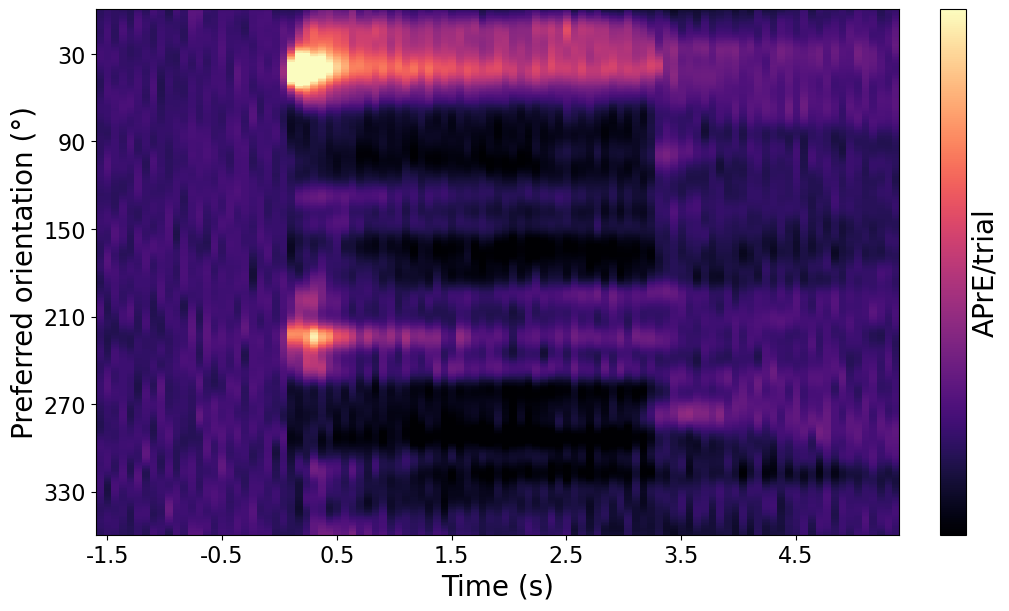

In [15]:
# Use the 'magma' colormap from seaborn
cmap = sns.color_palette("magma", as_cmap=True)

fig, axs = plt.subplots(1, 1, figsize=(10, 6), constrained_layout=True)

# Orientation Space Activity Map
im = axs.imshow(
    activity_map,
    aspect='auto',
    cmap=cmap,
    interpolation='nearest',
    vmin=-0.01,
    vmax=0.04
)

# Customize ticks and labels
axs.set_xlabel("Time (s)", fontsize=20)
axs.set_ylabel("Preferred orientation (°)", fontsize=20)
axs.set_yticks([30, 90, 150, 210, 270, 330])
axs.set_yticklabels(['30', '90', '150', '210', '270', '330'])
axs.tick_params(axis='both', which='major', labelsize=16)

# Time ticks from -1.5s to max time
frame_rate = 15
zero_index = 24
tick_secs = np.arange(-1.5, (activity_map.shape[1] - zero_index) / frame_rate + 0.01, 1)
x_ticks = [int(zero_index + s * frame_rate) for s in tick_secs]
x_labels = [f"{s:.1f}" for s in tick_secs]
axs.set_xticks(x_ticks)
axs.set_xticklabels(x_labels)

# Remove ticks and label from colorbar
cb = fig.colorbar(im, ax=axs)
cb.set_ticks([])
cb.set_label("APrE/trial", fontsize=20)

plt.show()